In [46]:
library(bbmle)
library(tidyverse)
library(deSolve)
dev.new(width=8, height=3.5)

## Dataset
Using the dataset obtained from Kelley Islands Influenza outbreak in 1920. 

S   E   I   R 
685   4   0   0

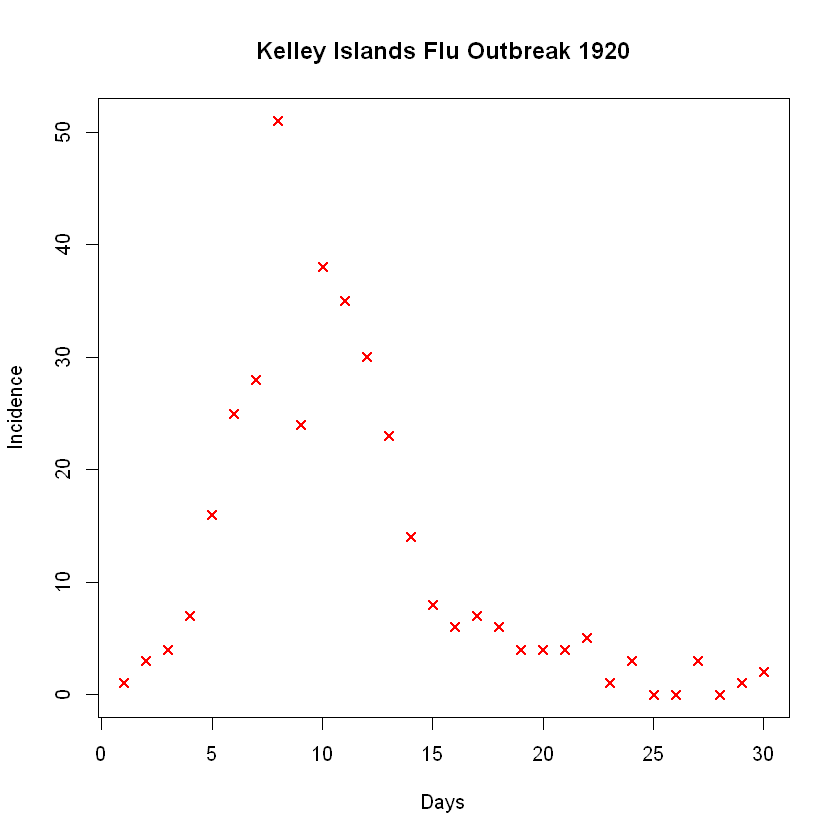

In [47]:
df <- select(data.frame(read.csv('Datasets/Chapter5.csv')), c('days', 'cases'))
plot(df$days, df$cases, xlab='Days', ylab='Incidence', col='red', pch=4, lwd=1.6)
title('Kelley Islands Flu Outbreak 1920')
N <- 689

initial_data <- c(S=N-4, E=4, I=0, R=0)
initial_data

## SEIR Model

$\frac{dS}{dt} = -\frac{\beta{S}{I}}{N}$

$\frac{dE}{dt} = \frac{\beta{S}{I}}{N} - \alpha{E}$

$\frac{dI}{dt} = \alpha {E} - \gamma{I}$

$\frac{dZ}{dt} = \gamma{I}$

In [48]:
model <- function(parameters, initial_conditions, time){
    equations <- function(time, variables, parameters) {
        with(as.list(c(variables, parameters)), {
            N <- S+E+I+R
            dS <- -beta * I * S/N
            dE <- beta * S*I/N - alpha * E
            dI <- alpha*E - gamma*I
            dR <-  gamma * I
            return(list(c(dS, dE, dI, dR)))
        })
    }
    out <- ode(
        y = initial_conditions,
        times = c(0,time),
        func = equations,
        parms = parameters
    )
    return(as.data.frame(out)[-1,])
}

Along with incidence curve generated by: 

$C_I(d) \approx \alpha h[\frac{1}{2}(E(d)+E(d+1)) + \sum_{j=1}^{m-1}{E(t_j)}]$

In [49]:
tau_incidence <- function(params, from, to, n=100){
    time_points <- seq(from, to, 1/n)
    model_data <- model(params, initial_conditions=initial_data, time=time_points)
    model_data$C <- params['beta']*model_data$S*model_data$I/N
    ends <- tail(model_data$C, n=1) + model_data$C[1] 
    total <- sum(model_data$C) - 0.5*ends
    return(1/n*total)
}

In [50]:
incidence_curve <- function(params, times){
    inc_data <- data.frame(time=times[1], incidence=tau_incidence(params, times[1], times[2]))
    for(i in 2:length(times)){
        instant <- tau_incidence(params, times[i-1], times[i])
        inc_data[nrow(inc_data) + 1,] = c(times[i-1], instant)
    }
    return(inc_data)
}

## SIR Model

In [51]:
sir <- function(beta, gamma, initial_conditions, times){
    equations <- function(time, variables, parameters) {
        with(as.list(c(variables, parameters)), {
            N <- X+Y+Z
            dX <- -beta * X * Y/N
            dY <- beta * X*Y/N - gamma * Y
            dZ <-  gamma * Y
            return(list(c(dX, dY, dZ)))
        })
    }
    out <- ode(
        y = initial_conditions,
        times = c(0,times),
        func = equations,
        parms = c(beta=beta, gamma=gamma) 
    )
    # Always have to pass t=0 state to ode solver as it gets it's IC from t=0.
    return(as.data.frame(out)[-1,])
}

## Least Squares

In [52]:
time_length <- 30
incidence_times <- seq(0, time_length, 0.1)
ss <- function(params){
    predictions <- incidence_curve(params, times = df$days)
    sum((predictions$incidence - df$cases)^2)
}
starting_param_val <- c(beta=1.9, gamma=1.4, alpha=0.5)
ss_optim <- optim(starting_param_val, ss)

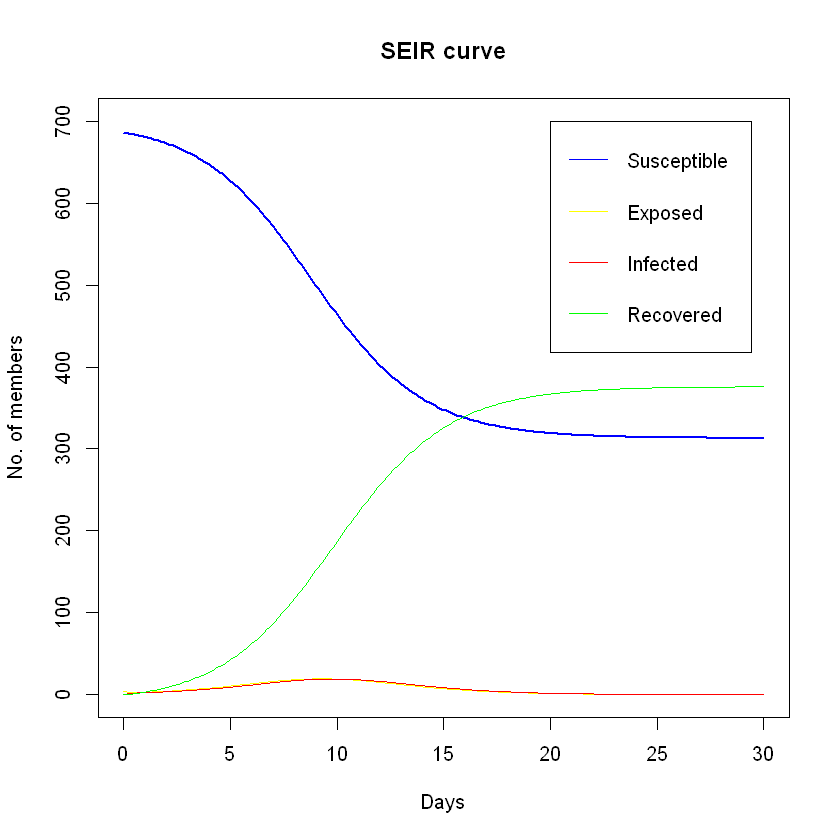

In [53]:
params<- ss_optim$par
times <- seq(0,time_length, 0.1)
data <- model(params, initial_data, times)
plot(loess(data$S~times),type='l', col='blue',  xlab='Days', ylab='No. of members', pch=4, lwd=1.6, ylim=c(0,700))

legend(20, 700, legend=c("Susceptible", "Exposed", "Infected", "Recovered"), col=c("blue", "yellow", "red","green"),
       lty=1, y.intersp=2)
lines(loess(data$E~times), type='l',col='yellow')
lines(loess(data$I~times),type='l', col='red' )
lines(loess(data$R~times),type='l', col='green')

title('SEIR curve')

In [54]:
params

beta    gamma    alpha 
2.723836 1.897784 1.897616

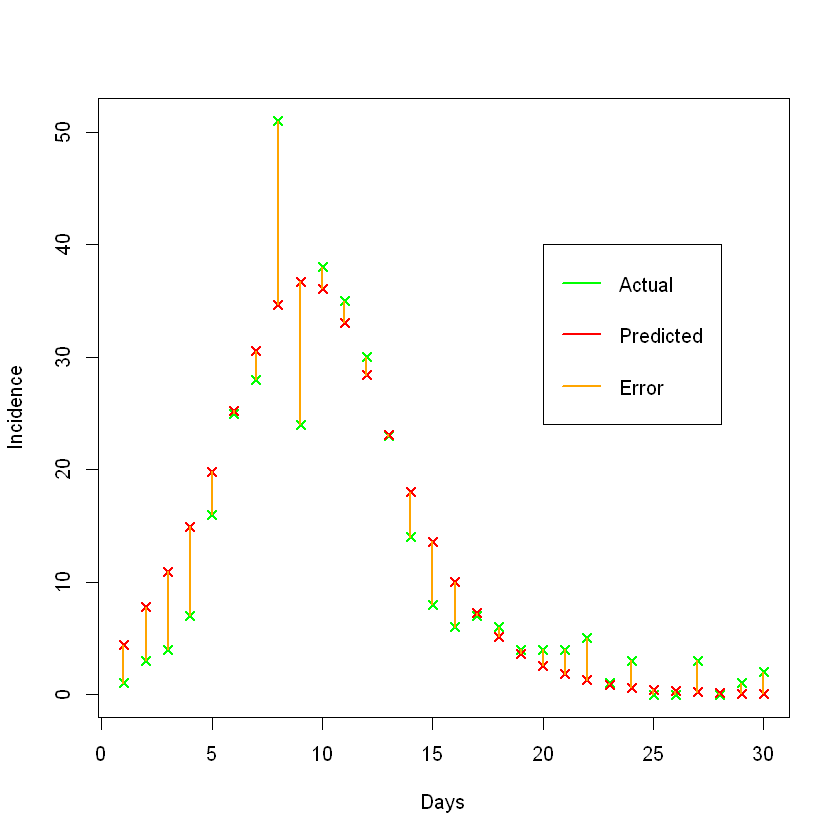

In [65]:
inc_data <- incidence_curve(params=params, times=seq(0,30))
plot(df$days, df$cases, xlab='Days', ylab='Incidence', col='green', pch=4, lwd=1.6)
points(df$days, inc_data[-1,]$incidence, col='red', pch=4, lwd=1.6)
legend(20, 40, legend=c("Actual", "Predicted", "Error"), col=c("green", "red", "orange"), lty=1:1,lwd=1.6, y.intersp=2)
arrows(df$days, df$cases,df$days, inc_data[-1,]$incidence, length=0.1, angle=90, code=0, col='orange', lwd=1.7)